## Setup

In [75]:
%matplotlib inline

In [76]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [77]:
from aif360.datasets import StandardDataset
StandardDataset??

In [78]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [79]:
import os
import shutil
import glob

## Arguments & Initializations

In [80]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [81]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [82]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [83]:
DATASET = "law_race"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 1 # int(args["os"])
ATTACK = "mia1"

In [84]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [85]:
ATTACK

'mia1'


## Loading & Splitting Dataset

In [86]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [87]:
dataset_orig.features.shape

(20798, 13)

In [88]:
privileged_groups

[{'race': 1}]

In [89]:
sens_attr

'race'

In [90]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [91]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[9. 8. 0. ... 4. 5. 5.]
 [1. 2. 0. ... 5. 6. 6.]
 [7. 6. 0. ... 6. 6. 7.]
 ...
 [2. 4. 0. ... 4. 3. 3.]
 [8. 7. 0. ... 3. 4. 4.]
 [1. 2. 0. ... 3. 4. 4.]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [92]:
seed = 1234
np.random.seed(seed)

In [93]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [94]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [95]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [96]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [97]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [98]:
target_dataset = None
reference_dataset = None

In [99]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
        print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

#### Train dataset's features are as below:
[[7. 7. 0. ... 4. 6. 8.]
 [7. 6. 0. ... 3. 6. 6.]
 [9. 8. 0. ... 3. 6. 8.]
 ...
 [6. 6. 0. ... 3. 6. 8.]
 [1. 1. 0. ... 4. 0. 0.]
 [1. 1. 0. ... 4. 6. 6.]]
no bias type specified
#### Training Dataset shape
(10399, 13)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'gender', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  480.0 9919.0
base_pos unpriv:  0.953523540679504
base_pos priv:  0.8770833333333333
number of favorable labels:  9879
Difference in mean outcomes between unprivileged and privileged groups = 0.076440
#### Train shape, validation shape, test shape
(10399, 13) (10399, 13) (10399, 13)
#############

RUN DIRMITIGATOR
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 461
Number of test samples (ntest): 463
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9458
Number of test samples (ntest): 9483
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 421
Number of test samples (ntest): 396
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.39      0.53       520
         1.0       0.97      1.00      0.98      9879

    accuracy                           0.97     10399
   macro avg       0.90      0.69      0.76     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9657659390325993
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 461
Number of test samples (ntest): 463
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9458
Number of test samples (ntest): 9483
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 421
Number of test samples (ntest): 396
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.61      0.24      0.34       520
         1.0       0.96      0.99      0.98      9879

    accuracy                           0.95     10399
   macro avg       0.79      0.61      0.66     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9543225310125973
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.27
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.5665761929546531
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 520, Test = 520
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.37
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.15
  Positive predictive value: 0.63
  Optimal thershold: -1.5665761929546531
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9879, Test = 9879
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.060849646701372606
)
MIA_Result(
  Name: subpopulation_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9460
Number of test samples (ntest): 9481
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 422
Number of test samples (ntest): 395
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.49      0.63       517
         1.0       0.97      1.00      0.99      9882

    accuracy                           0.97     10399
   macro avg       0.93      0.74      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9712472353110876
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Tes

Number of training samples (ntrain): 9460
Number of test samples (ntest): 9481
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 422
Number of test samples (ntest): 395
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.42      0.57       517
         1.0       0.97      1.00      0.98      9882

    accuracy                           0.97     10399
   macro avg       0.91      0.71      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9678815270699106
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 462
Number of test samples (ntest): 462
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9460
Number of test samples (ntest): 9481
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 422
Number of test samples (ntest): 395
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.66      0.24      0.35       517
         1.0       0.96      0.99      0.98      9882

    accuracy                           0.96     10399
   macro avg       0.81      0.62      0.66     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9560534666794884
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.43
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 517, Test = 523
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.16
  Positive predictive value: 0.71
  Optimal thershold: -1.542238247156989
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9882, Test = 9876
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9495
Number of test samples (ntest): 9446
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 410
Number of test samples (ntest): 407
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.92      0.45      0.60       494
         1.0       0.97      1.00      0.99      9905

    accuracy                           0.97     10399
   macro avg       0.95      0.72      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.971920376959323
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test

Number of training samples (ntrain): 9495
Number of test samples (ntest): 9446
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 410
Number of test samples (ntest): 407
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.44      0.60       494
         1.0       0.97      1.00      0.99      9905

    accuracy                           0.97     10399
   macro avg       0.95      0.72      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9718242138667179
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.82
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 445
Number of test samples (ntest): 479
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9495
Number of test samples (ntest): 9446
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 410
Number of test samples (ntest): 407
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.27      0.38       494
         1.0       0.96      0.99      0.98      9905

    accuracy                           0.96     10399
   macro avg       0.80      0.63      0.68     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9580728916241946
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.39
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.4804361972892131
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 494, Test = 546
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.15
  Positive predictive value: 0.67
  Optimal thershold: -5.528844175017487
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9905, Test = 9853
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9466
Number of test samples (ntest): 9475
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 428
Number of test samples (ntest): 389
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.85      0.46      0.59       505
         1.0       0.97      1.00      0.98      9894

    accuracy                           0.97     10399
   macro avg       0.91      0.73      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9696124627368016
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.77
  Tes

Number of training samples (ntrain): 9466
Number of test samples (ntest): 9475
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 428
Number of test samples (ntest): 389
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.40      0.56       505
         1.0       0.97      1.00      0.98      9894

    accuracy                           0.97     10399
   macro avg       0.93      0.70      0.77     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9687469949033561
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.77
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 450
Number of test samples (ntest): 474
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9466
Number of test samples (ntest): 9475
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 428
Number of test samples (ntest): 389
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.25      0.36       505
         1.0       0.96      0.99      0.98      9894

    accuracy                           0.96     10399
   macro avg       0.80      0.62      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9568227714203289
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.49
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 505, Test = 535
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.57
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.13
  Positive predictive value: 0.63
  Optimal thershold: -1.9057426425934674
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9894, Test = 9864
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9462
Number of test samples (ntest): 9479
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 423
Number of test samples (ntest): 394
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.46      0.60       514
         1.0       0.97      1.00      0.98      9885

    accuracy                           0.97     10399
   macro avg       0.91      0.73      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9693239734589865
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.73
  Tes

Number of training samples (ntrain): 9462
Number of test samples (ntest): 9479
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 423
Number of test samples (ntest): 394
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.47      0.61       514
         1.0       0.97      1.00      0.98      9885

    accuracy                           0.97     10399
   macro avg       0.92      0.73      0.80     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.970189441292432
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.69
  Tes

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 461
Number of test samples (ntest): 463
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9462
Number of test samples (ntest): 9479
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 423
Number of test samples (ntest): 394
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.68      0.26      0.37       514
         1.0       0.96      0.99      0.98      9885

    accuracy                           0.96     10399
   macro avg       0.82      0.63      0.68     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9573035868833542
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.04
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -3.503616189893814
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 514, Test = 526
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.15
  Positive predictive value: 0.70
  Optimal thershold: -3.503616189893814
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9885, Test = 9873
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation_0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9469
Number of test samples (ntest): 9472
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 406
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.49      0.63       519
         1.0       0.97      1.00      0.98      9880

    accuracy                           0.97     10399
   macro avg       0.93      0.74      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9711510722184825
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Tes

Number of training samples (ntrain): 9469
Number of test samples (ntest): 9472
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 406
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.44      0.58       519
         1.0       0.97      1.00      0.98      9880

    accuracy                           0.97     10399
   macro avg       0.92      0.72      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9684585056255409
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 464
Number of test samples (ntest): 460
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9469
Number of test samples (ntest): 9472
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 55
Number of test samples (ntest): 61
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 406
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.66      0.25      0.36       519
         1.0       0.96      0.99      0.98      9880

    accuracy                           0.96     10399
   macro avg       0.81      0.62      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9560534666794884
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.5
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.6225361146072097
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 519, Test = 521
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.14
  Positive predictive value: 0.64
  Optimal thershold: -3.189124871885564
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9880, Test = 9878
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.04208103403961987
)
MIA_Result(
  Name: subpopulation_0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9465
Number of test samples (ntest): 9476
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 425
Number of test samples (ntest): 392
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.82      0.46      0.59       509
         1.0       0.97      0.99      0.98      9890

    accuracy                           0.97     10399
   macro avg       0.90      0.73      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.968554668718146
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test

Number of training samples (ntrain): 9465
Number of test samples (ntest): 9476
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 425
Number of test samples (ntest): 392
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.38      0.53       509
         1.0       0.97      1.00      0.98      9890

    accuracy                           0.97     10399
   macro avg       0.92      0.69      0.75     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9666314068660448
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 450
Number of test samples (ntest): 474
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9465
Number of test samples (ntest): 9476
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 425
Number of test samples (ntest): 392
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.25      0.36       509
         1.0       0.96      0.99      0.98      9890

    accuracy                           0.96     10399
   macro avg       0.80      0.62      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9564381190499086
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.19
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 509, Test = 531
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.15
  Positive predictive value: 0.76
  Optimal thershold: -2.9553457032518664
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9890, Test = 9868
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9500
Number of test samples (ntest): 9441
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 397
Number of test samples (ntest): 420
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.85      0.47      0.60       502
         1.0       0.97      1.00      0.98      9897

    accuracy                           0.97     10399
   macro avg       0.91      0.73      0.79     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9704779305702471
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Tes

Number of training samples (ntrain): 9500
Number of test samples (ntest): 9441
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 397
Number of test samples (ntest): 420
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.93      0.39      0.55       502
         1.0       0.97      1.00      0.98      9897

    accuracy                           0.97     10399
   macro avg       0.95      0.69      0.77     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9691316472737763
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 453
Number of test samples (ntest): 471
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9500
Number of test samples (ntest): 9441
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 397
Number of test samples (ntest): 420
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.21      0.31       502
         1.0       0.96      0.99      0.98      9897

    accuracy                           0.96     10399
   macro avg       0.80      0.60      0.65     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9561496297720935
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.12
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 502, Test = 538
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.75
  Attacker advantage: 0.16
  Positive predictive value: 0.69
  Optimal thershold: -2.907398859040859
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9897, Test = 9861
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9483
Number of test samples (ntest): 9458
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 60
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 396
Number of test samples (ntest): 421
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.92      0.44      0.59       520
         1.0       0.97      1.00      0.98      9879

    accuracy                           0.97     10399
   macro avg       0.95      0.72      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9699971151072219
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.24000000000000002
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (

Best thresh:  0.43
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: -0.05129329438755058
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 520, Test = 520
  AUC: 0.74
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.35
  Positive predictive value: 0.75
  Optimal thershold: -1.7917594692280552
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9879, Test = 9879
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.02
  Positive predictive value: 0.52
  Optimal thershold: -0.05129329438755058
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 460
Number of test samples (ntest): 464
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9483
Number of test samples (ntest): 9458
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 60
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 396
Number of test samples (ntest): 421
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.63      0.21      0.32       520
         1.0       0.96      0.99      0.98      9879

    accuracy                           0.95     10399
   macro avg       0.80      0.60      0.65     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9544186941052024
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.29000000000000004
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 520, Test = 520
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.72
  Attacker advantage: 0.11
  Positive predictive value: 0.64
  Optimal thershold: -3.7737411353370294
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9879, Test = 9879
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9479
Number of test samples (ntest): 9462
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 416
Number of test samples (ntest): 401
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.92      0.43      0.58       504
         1.0       0.97      1.00      0.98      9895

    accuracy                           0.97     10399
   macro avg       0.95      0.71      0.78     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.970381767477642
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test

Number of training samples (ntrain): 9479
Number of test samples (ntest): 9462
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 416
Number of test samples (ntest): 401
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.50      0.63       504
         1.0       0.97      1.00      0.99      9895

    accuracy                           0.97     10399
   macro avg       0.92      0.75      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9721127031445331
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Tes

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 445
Number of test samples (ntest): 479
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9479
Number of test samples (ntest): 9462
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 416
Number of test samples (ntest): 401
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.61      0.24      0.35       504
         1.0       0.96      0.99      0.98      9895

    accuracy                           0.96     10399
   macro avg       0.78      0.62      0.66     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9556688143090681
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.49
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 504, Test = 536
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.15
  Positive predictive value: 0.72
  Optimal thershold: -1.1587288185336275
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9895, Test = 9863
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9478
Number of test samples (ntest): 9463
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 60
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 398
Number of test samples (ntest): 419
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.91      0.36      0.52       523
         1.0       0.97      1.00      0.98      9876

    accuracy                           0.97     10399
   macro avg       0.94      0.68      0.75     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9661505914030195
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.70
  Tes

Number of training samples (ntrain): 9478
Number of test samples (ntest): 9463
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 60
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 398
Number of test samples (ntest): 419
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.85      0.38      0.53       523
         1.0       0.97      1.00      0.98      9876

    accuracy                           0.97     10399
   macro avg       0.91      0.69      0.75     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9655736128473892
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 463
Number of test samples (ntest): 461
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9478
Number of test samples (ntest): 9463
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 60
Number of test samples (ntest): 56
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 398
Number of test samples (ntest): 419
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.60      0.20      0.30       523
         1.0       0.96      0.99      0.98      9876

    accuracy                           0.95     10399
   macro avg       0.78      0.60      0.64     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9531685739013367
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.31
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.5521555112076824
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 523, Test = 517
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.75
  Attacker advantage: 0.10
  Positive predictive value: 0.65
  Optimal thershold: -2.3771331520838084
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9876, Test = 9882
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9454
Number of test samples (ntest): 9487
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 415
Number of test samples (ntest): 402
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.46      0.60       530
         1.0       0.97      1.00      0.98      9869

    accuracy                           0.97     10399
   macro avg       0.92      0.73      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9686508318107511
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.78
  Te

Number of training samples (ntrain): 9454
Number of test samples (ntest): 9487
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 415
Number of test samples (ntest): 402
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.45      0.59       530
         1.0       0.97      1.00      0.98      9869

    accuracy                           0.97     10399
   macro avg       0.92      0.72      0.79     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9683623425329358
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.69
  Tes

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 468
Number of test samples (ntest): 456
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9454
Number of test samples (ntest): 9487
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 415
Number of test samples (ntest): 402
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.60      0.25      0.35       530
         1.0       0.96      0.99      0.98      9869

    accuracy                           0.95     10399
   macro avg       0.78      0.62      0.66     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9532647369939418
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.44
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.13
  Positive predictive value: 0.68
  Optimal thershold: -2.02409422268316
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9435
Number of test samples (ntest): 9506
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 437
Number of test samples (ntest): 380
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.37      0.53       527
         1.0       0.97      1.00      0.98      9872

    accuracy                           0.97     10399
   macro avg       0.93      0.69      0.75     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9657659390325993
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Tes

Number of training samples (ntrain): 9435
Number of test samples (ntest): 9506
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 437
Number of test samples (ntest): 380
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.42      0.57       527
         1.0       0.97      1.00      0.98      9872

    accuracy                           0.97     10399
   macro avg       0.93      0.71      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9677853639773055
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Tes

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 465
Number of test samples (ntest): 459
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9435
Number of test samples (ntest): 9506
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 437
Number of test samples (ntest): 380
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.25      0.36       527
         1.0       0.96      0.99      0.98      9872

    accuracy                           0.95     10399
   macro avg       0.80      0.62      0.67     10399
weighted avg       0.94      0.95      0.95     10399

Train accuracy:  0.9548033464756227
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.26
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 527, Test = 513
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.09
  Positive predictive value: 0.68
  Optimal thershold: -2.628792976420495
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9872, Test = 9886
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9482
Number of test samples (ntest): 9459
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 55
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 401
Number of test samples (ntest): 416
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.90      0.42      0.58       516
         1.0       0.97      1.00      0.98      9883

    accuracy                           0.97     10399
   macro avg       0.94      0.71      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9691316472737763
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.86
  Tes

Number of training samples (ntrain): 9482
Number of test samples (ntest): 9459
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 55
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 401
Number of test samples (ntest): 416
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.40      0.55       516
         1.0       0.97      1.00      0.98      9883

    accuracy                           0.97     10399
   macro avg       0.93      0.70      0.77     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9674968746994903
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 455
Number of test samples (ntest): 469
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9482
Number of test samples (ntest): 9459
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 61
Number of test samples (ntest): 55
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 401
Number of test samples (ntest): 416
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.66      0.24      0.35       516
         1.0       0.96      0.99      0.98      9883

    accuracy                           0.96     10399
   macro avg       0.81      0.62      0.67     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9561496297720935
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.4
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 516, Test = 524
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.33
  Test Accuracy (TNR): 0.82
  Attacker advantage: 0.15
  Positive predictive value: 0.74
  Optimal thershold: -0.9376312651507165
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9883, Test = 9875
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9457
Number of test samples (ntest): 9484
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 393
Number of test samples (ntest): 424
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.48      0.61       549
         1.0       0.97      1.00      0.98      9850

    accuracy                           0.97     10399
   macro avg       0.91      0.74      0.80     10399
weighted avg       0.96      0.97      0.96     10399

Train accuracy:  0.9676892008847005
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.10
  Tes

Number of training samples (ntrain): 9457
Number of test samples (ntest): 9484
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 393
Number of test samples (ntest): 424
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.46      0.61       549
         1.0       0.97      1.00      0.98      9850

    accuracy                           0.97     10399
   macro avg       0.93      0.73      0.80     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9686508318107511
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 487
Number of test samples (ntest): 437
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9457
Number of test samples (ntest): 9484
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 393
Number of test samples (ntest): 424
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.66      0.26      0.37       549
         1.0       0.96      0.99      0.98      9850

    accuracy                           0.95     10399
   macro avg       0.81      0.63      0.67     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9538417155495721
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.4
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 549, Test = 491
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.55
  Train Accuracy (TPR): 0.34
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.13
  Positive predictive value: 0.69
  Optimal thershold: -1.9554687689310024
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9850, Test = 9908
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9476
Number of test samples (ntest): 9465
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 405
Number of test samples (ntest): 412
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.43      0.58       518
         1.0       0.97      1.00      0.98      9881

    accuracy                           0.97     10399
   macro avg       0.92      0.72      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9686508318107511
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Tes

Number of training samples (ntrain): 9476
Number of test samples (ntest): 9465
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 405
Number of test samples (ntest): 412
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.42      0.57       518
         1.0       0.97      1.00      0.98      9881

    accuracy                           0.97     10399
   macro avg       0.93      0.71      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9683623425329358
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 459
Number of test samples (ntest): 465
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9476
Number of test samples (ntest): 9465
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 59
Number of test samples (ntest): 57
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 405
Number of test samples (ntest): 412
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.64      0.26      0.37       518
         1.0       0.96      0.99      0.98      9881

    accuracy                           0.96     10399
   macro avg       0.80      0.63      0.68     10399
weighted avg       0.95      0.96      0.95     10399

Train accuracy:  0.9560534666794884
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.42000000000000004
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 518, Test = 522
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.12
  Positive predictive value: 0.80
  Optimal thershold: -1.3958959484511546
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9881, Test = 9877
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9486
Number of test samples (ntest): 9455
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 409
Number of test samples (ntest): 408
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.90      0.46      0.61       504
         1.0       0.97      1.00      0.99      9895

    accuracy                           0.97     10399
   macro avg       0.93      0.73      0.80     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9713433984036927
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Tes

Number of training samples (ntrain): 9486
Number of test samples (ntest): 9455
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 409
Number of test samples (ntest): 408
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.49      0.62       504
         1.0       0.97      1.00      0.98      9895

    accuracy                           0.97     10399
   macro avg       0.91      0.74      0.80     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9709587460332725
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 455
Number of test samples (ntest): 469
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9486
Number of test samples (ntest): 9455
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 49
Number of test samples (ntest): 67
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 409
Number of test samples (ntest): 408
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.58      0.25      0.35       504
         1.0       0.96      0.99      0.98      9895

    accuracy                           0.95     10399
   macro avg       0.77      0.62      0.66     10399
weighted avg       0.94      0.95      0.95     10399

Train accuracy:  0.9549956726608327
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.44
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 504, Test = 536
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.14
  Positive predictive value: 0.65
  Optimal thershold: -1.0632292138904165
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9895, Test = 9863
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9455
Number of test samples (ntest): 9486
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 69
Number of test samples (ntest): 47
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 406
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.50      0.63       533
         1.0       0.97      1.00      0.98      9866

    accuracy                           0.97     10399
   macro avg       0.92      0.75      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.970381767477642
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test

Number of training samples (ntrain): 9455
Number of test samples (ntest): 9486
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 69
Number of test samples (ntest): 47
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 406
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.91      0.47      0.62       533
         1.0       0.97      1.00      0.98      9866

    accuracy                           0.97     10399
   macro avg       0.94      0.73      0.80     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.970285604385037
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (T

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 464
Number of test samples (ntest): 460
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9455
Number of test samples (ntest): 9486
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 69
Number of test samples (ntest): 47
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 411
Number of test samples (ntest): 406
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.59      0.27      0.37       533
         1.0       0.96      0.99      0.98      9866

    accuracy                           0.95     10399
   macro avg       0.78      0.63      0.68     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9531685739013367
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.44
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.265095184244797
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 533, Test = 507
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.72
  Attacker advantage: 0.16
  Positive predictive value: 0.71
  Optimal thershold: -1.4572874926462758
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9866, Test = 9892
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulation_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9501
Number of test samples (ntest): 9440
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 384
Number of test samples (ntest): 433
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.87      0.51      0.64       514
         1.0       0.97      1.00      0.99      9885

    accuracy                           0.97     10399
   macro avg       0.92      0.75      0.81     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.971728050774113
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
  Test

Number of training samples (ntrain): 9501
Number of test samples (ntest): 9440
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 384
Number of test samples (ntest): 433
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.90      0.46      0.61       514
         1.0       0.97      1.00      0.98      9885

    accuracy                           0.97     10399
   macro avg       0.94      0.73      0.80     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9709587460332725
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.49
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Te

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 461
Number of test samples (ntest): 463
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9501
Number of test samples (ntest): 9440
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 53
Number of test samples (ntest): 63
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 384
Number of test samples (ntest): 433
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.60      0.24      0.34       514
         1.0       0.96      0.99      0.98      9885

    accuracy                           0.95     10399
   macro avg       0.78      0.62      0.66     10399
weighted avg       0.94      0.95      0.95     10399

Train accuracy:  0.9546110202904126
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.49
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 514, Test = 526
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.16
  Positive predictive value: 0.71
  Optimal thershold: -2.709052594779256
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9885, Test = 9873
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 9464
Number of test samples (ntest): 9477
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 421
Number of test samples (ntest): 396
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.89      0.47      0.61       514
         1.0       0.97      1.00      0.98      9885

    accuracy                           0.97     10399
   macro avg       0.93      0.73      0.80     10399
weighted avg       0.97      0.97      0.97     10399

Train accuracy:  0.9706702567554573
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.5
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 1.00
  Tes

Number of training samples (ntrain): 9464
Number of test samples (ntest): 9477
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 421
Number of test samples (ntest): 396
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.90      0.39      0.54       514
         1.0       0.97      1.00      0.98      9885

    accuracy                           0.97     10399
   macro avg       0.93      0.69      0.76     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9674968746994903
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.48000000000000004
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 452
Number of test samples (ntest): 472
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9464
Number of test samples (ntest): 9477
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 62
Number of test samples (ntest): 54
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 421
Number of test samples (ntest): 396
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.59      0.19      0.29       514
         1.0       0.96      0.99      0.98      9885

    accuracy                           0.95     10399
   macro avg       0.77      0.59      0.63     10399
weighted avg       0.94      0.95      0.94     10399

Train accuracy:  0.9534570631791518
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.49
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 514, Test = 526
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.75
  Attacker advantage: 0.11
  Positive predictive value: 0.70
  Optimal thershold: -2.0358436802277513
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9885, Test = 9873
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [100]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [101]:
df_bank['race'].value_counts()

race
0.0    19865
1.0      933
Name: count, dtype: int64

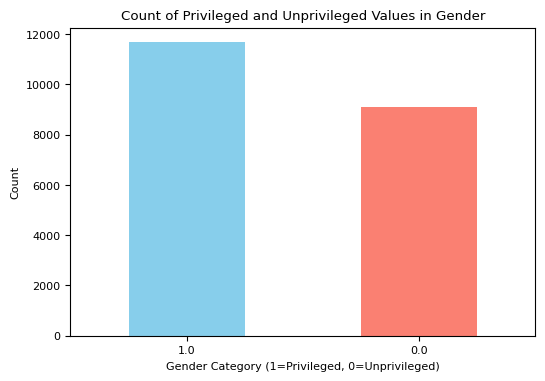

In [102]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [103]:
y_counts = df_bank['y'].value_counts()

KeyError: 'y'

In [ ]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_bank.shape

## Display Output

In [104]:
priv_metric_orig_copy = priv_metric_orig

In [105]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 9375.0, 'total_unpriv': 198605.0})

In [106]:
priv_metric_orig

defaultdict(float, {'total_priv': 9375.0, 'total_unpriv': 198605.0})

In [107]:
priv_metric_orig.items()

dict_items([('total_priv', 9375.0), ('total_unpriv', 198605.0)])

In [108]:
priv_metric_orig = priv_metric_orig_copy

In [109]:
orig_metrics.items()

dict_items([('bal_acc', [0.5680153900659518, 0.5735876300156355, 0.5657012479046377, 0.5844352350850065, 0.5827623941933275, 0.5824119517227255, 0.5782053807051575, 0.5564519686090186, 0.5662947627835269, 0.5642241809809313, 0.5660632014835014, 0.5706227358978783, 0.563908182914859, 0.5669259831867813, 0.5776944220843985, 0.57900655068841, 0.5724575944166423, 0.5779911206712973, 0.5652469826877389, 0.5720918979018323]), ('avg_odds_diff', [0.06669564927348748, 0.11476033055668555, 0.052147121420709985, 0.008298817920466217, 0.0689185033345831, 0.030900299512010565, 0.15500944858828514, 0.08581607180432527, 0.07747344696327002, 0.041048903963653405, 0.0010802283300220261, 0.05881490029904746, 0.028512458217747783, 0.004518913583974216, 0.10343494246865503, 0.059008827697442756, 0.04452150103196201, 0.07788240287497139, 0.09039422642731643, 0.033816280206738436]), ('disp_imp', [0.048827774004554625, 0.08328064907012278, 0.03999853064049286, 0.03567127242730472, 0.06783913338681125, 0.0300

In [110]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

law_race
10399
2)

              total_priv  total_unpriv
num_instance                          
orig              468.75       9930.25
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.950322       0.049678    0.877158      0.122842      0.953778   
transf      0.950322       0.049678    0.877158      0.122842      0.953778   

         unpriv_unfavor  
dataset                  
orig           0.046222  
transf         0.046222  


In [111]:
orig_metrics.items()

dict_items([('bal_acc', [0.5680153900659518, 0.5735876300156355, 0.5657012479046377, 0.5844352350850065, 0.5827623941933275, 0.5824119517227255, 0.5782053807051575, 0.5564519686090186, 0.5662947627835269, 0.5642241809809313, 0.5660632014835014, 0.5706227358978783, 0.563908182914859, 0.5669259831867813, 0.5776944220843985, 0.57900655068841, 0.5724575944166423, 0.5779911206712973, 0.5652469826877389, 0.5720918979018323]), ('avg_odds_diff', [0.06669564927348748, 0.11476033055668555, 0.052147121420709985, 0.008298817920466217, 0.0689185033345831, 0.030900299512010565, 0.15500944858828514, 0.08581607180432527, 0.07747344696327002, 0.041048903963653405, 0.0010802283300220261, 0.05881490029904746, 0.028512458217747783, 0.004518913583974216, 0.10343494246865503, 0.059008827697442756, 0.04452150103196201, 0.07788240287497139, 0.09039422642731643, 0.033816280206738436]), ('disp_imp', [0.048827774004554625, 0.08328064907012278, 0.03999853064049286, 0.03567127242730472, 0.06783913338681125, 0.0300

In [112]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

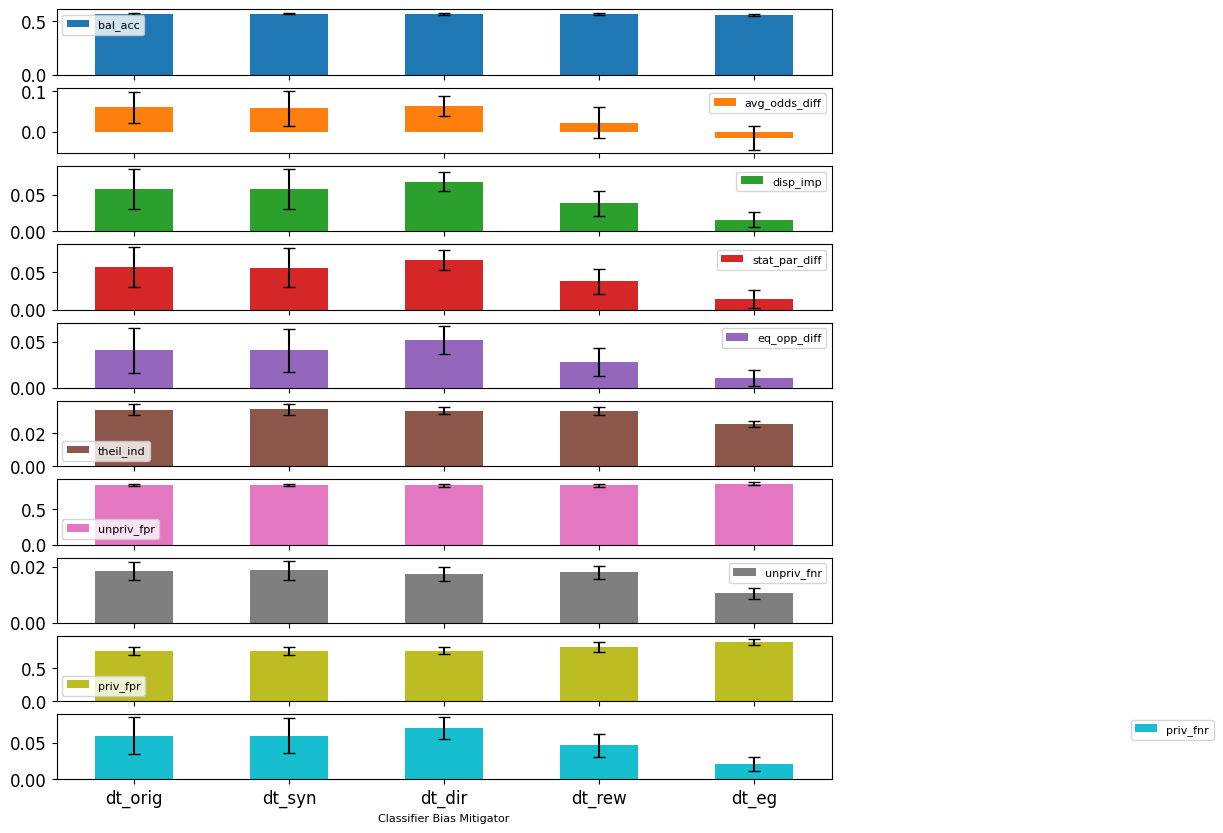

In [113]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [114]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [115]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.517225,0.679492,0.511244,0.678020,0.510536,0.719132,0.541958
syn,0.517264,0.678826,0.511262,0.676508,0.510574,0.720043,0.541798
dir,0.519872,0.678710,0.514498,0.674025,0.513998,0.747825,0.547308
rew,0.516141,0.675744,0.510689,0.680486,0.510242,0.677031,0.535269
eg,0.506212,0.568458,0.504434,0.564695,0.503954,0.626856,0.518166


In [116]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [117]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [118]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.678020,0.510536,0.719132,0.541958
syn,0.676508,0.510574,0.720043,0.541798
dir,0.674025,0.513998,0.747825,0.547308
rew,0.680486,0.510242,0.677031,0.535269
eg,0.564695,0.503954,0.626856,0.518166


<Axes: xlabel='Classifier MIA Attacks'>

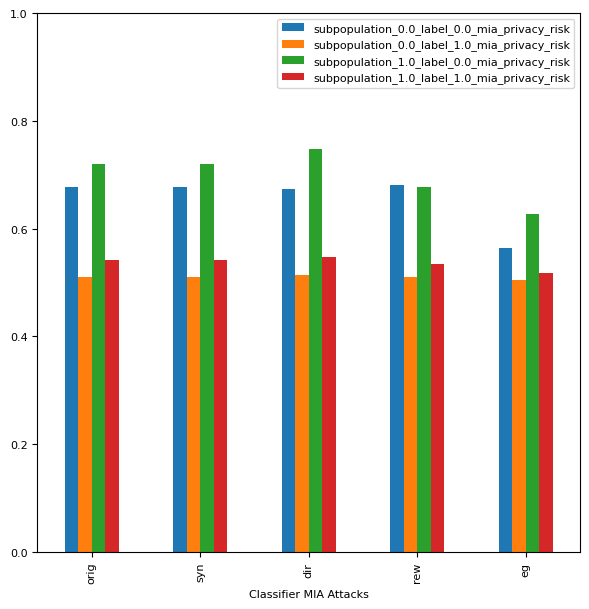

In [119]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [120]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.67802   0.676508  0.674025  0.680486  0.564695
subpopulation_0.0_label_1.0_mia_privacy_risk  0.510536  0.510574  0.513998  0.510242  0.503954
subpopulation_1.0_label_0.0_mia_privacy_risk  0.719132  0.720043  0.747825  0.677031  0.626856
subpopulation_1.0_label_1.0_mia_privacy_risk  0.541958  0.541798  0.547308  0.535269  0.518166


### Visualizing using novel technique

In [95]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


In [98]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


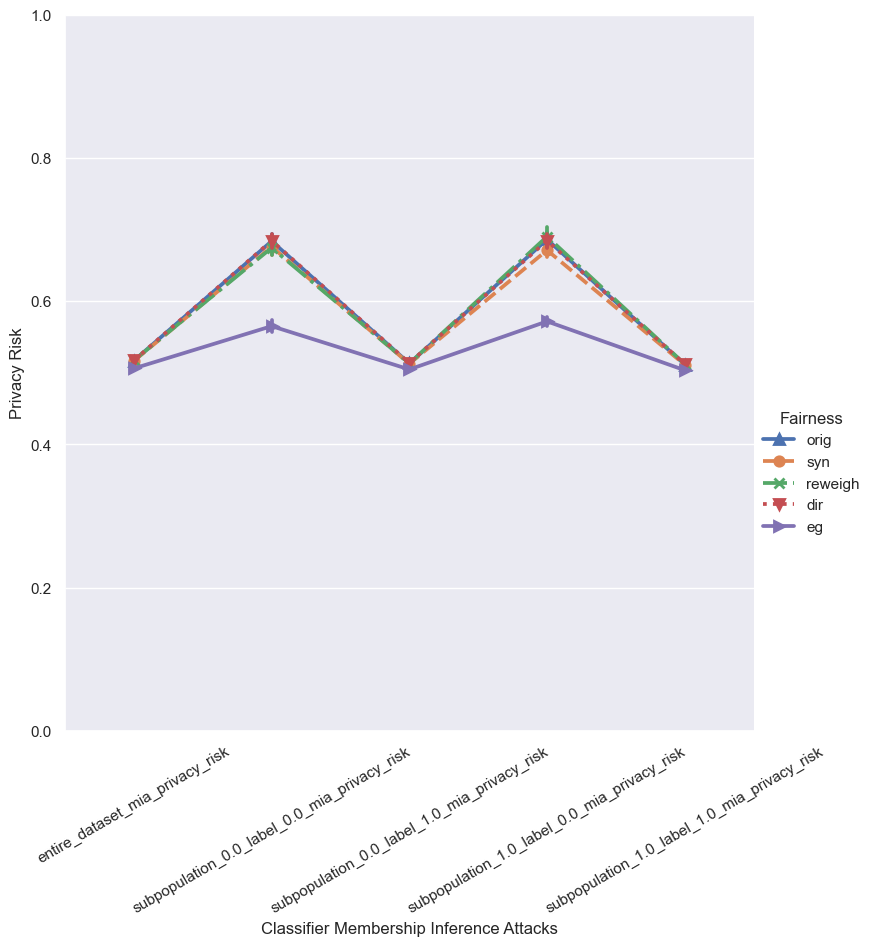

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr